In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### **Parameter Settings**

In [1]:
img_size=96
batch_size=16

# **DATASET**

### **Dataset Source**

In [2]:
import pandas as pd
# Load CSV
csv_path = '/kaggle/input/plantclef/PlantCLEF2024singleplanttrainingdata.csv'
df = pd.read_csv(csv_path, sep=';', low_memory=False)

# Show the shape and first few rows
print(f"Shape: {df.shape}")
df.head()

Shape: (1408033, 20)


,image_name,organ,species_id,obs_id,license,partner,author,altitude,latitude,longitude,gbif_species_id,species,genus,family,dataset,publisher,references,url,learn_tag,image_backup_url
0,59feabe1c98f06e7f819f73c8246bd8f1a89556b.jpg,leaf,1396710,1008726402,cc-by-sa,NaN,Gulyás Bálint,205.9261,47.592160,19.362895,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/59feabe1c98f06...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
1,dc273995a89827437d447f29a52ccac86f65476e.jpg,leaf,1396710,1008724195,cc-by-sa,NaN,vadim sigaud,323.7520,47.906703,7.201746,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/dc273995a89827...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
2,416235e7023a4bd1513edf036b6097efc693a304.jpg,leaf,1396710,1008721908,cc-by-sa,NaN,fil escande,101.3160,48.826774,2.352774,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/416235e7023a4b...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
3,cbd18fade82c46a5c725f1f3d982174895158afc.jpg,leaf,1396710,1008699177,cc-by-sa,NaN,Desiree Verver,5.1070,52.190427,6.009677,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/cbd18fade82c46...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...
4,f82c8c6d570287ebed8407cefcfcb2a51eaaf56e.jpg,leaf,1396710,1008683100,cc-by-sa,NaN,branebrane,165.3390,45.794739,15.965862,5284517.0,Taxus baccata L.,Taxus,Taxaceae,plantnet,plantnet,https://identify.plantnet.org/fr/k-southwester...,https://bs.plantnet.org/image/o/f82c8c6d570287...,train,https://lab.plantnet.org/LifeCLEF/PlantCLEF202...


### **Filter and Preprepare Dataset - One Image One Plant**

In [3]:

#--------------------------------------------------------
# Filter data to be more focused to 5 families with only 1 organ

# Drop rows without a valid 'family'
df = df.dropna(subset=['image_backup_url', 'family']).reset_index(drop=True)

# Count frequency of each family
family_counts = df['family'].value_counts()

# Select top 5 most common families
top_families = family_counts.head(5).index.tolist()

# Filter dataset to only include those families, and only 1 organ
df = df[df['family'].isin(top_families)].reset_index(drop=True)
df = df[df['organ'] == 'flower'].reset_index(drop=True)

# For each family, keep only 1000 samples
df = df.groupby('family').head(2000).reset_index(drop=True)
#---------------------------------------------------------------
# Manage Labels
# Create new label mappings based on the 5 families
label_to_idx = {fam: i for i, fam in enumerate(sorted(df['family'].unique()))}

# Add new column in dataframe - "label"; Map family to integer label
df['label'] = df['family'].map(label_to_idx).astype(int)

#-----------------------------------------------------------------------


In [4]:
# Checks
print(f"Total samples after filtering: {len(df)}")
print(f"Unique families: {df['family'].unique()}")
print("Number of samples per family:")
print(df['family'].value_counts())
print("")


Total samples after filtering: 10000
Unique families: ['Rosaceae' 'Fabaceae' 'Asteraceae' 'Poaceae' 'Brassicaceae']
Number of samples per family:
family
Rosaceae        2000
Fabaceae        2000
Asteraceae      2000
Poaceae         2000
Brassicaceae    2000
Name: count, dtype: int64



### **Download and Cache Images**

In [5]:
import os
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm

def download_images_from_df(df, output_dir='cached_images'):
    os.makedirs(output_dir, exist_ok=True)
    cached_paths = []

    print(f"Downloading {len(df)} images to '{output_dir}'...")
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        url = row['url']
        label = row['label']
        filename = f"{idx}_{label}.jpg"
        filepath = os.path.join(output_dir, filename)

        if not os.path.exists(filepath):
            try:
                response = requests.get(url, timeout=10)
                image = Image.open(BytesIO(response.content)).convert('RGB')
                image.save(filepath)
            except Exception as e:
                print(f"Failed to download {url}: {e}")
                filepath = None  # mark as missing

        cached_paths.append(filepath)

    df = df.copy()
    df['cached_path'] = cached_paths
    df = df[df['cached_path'].notnull()].reset_index(drop=True)  # drop any failed
    return df


In [6]:
# Download and cache images
df = download_images_from_df(df, output_dir='plant_cache')

# Save filtered df for future reuse
df.to_csv("filtered_cached.csv", index=False)

#df = pd.read_csv("filtered_cached.csv")

100%|██████████| 10000/10000 [2:08:28<00:00,  1.30it/s] 


In [9]:
import shutil
shutil.make_archive('cached_images', 'zip', 'plant_cache')

# import zipfile 
# with zipfile.ZipFile('/kaggle/input/cached_images.zip', 'r') as zip_ref:
#     zip_ref.extractall('images')

# import pandas as pd

# df = pd.read_csv('/kaggle/input/your-dataset-name/filtered_cached.csv')

# df['cached_path'] = df['cached_path'].apply(lambda x: f"/kaggle/input/your-dataset-name/images/{os.path.basename(x)}")
# df.head()

'/kaggle/working/cached_images.zip'

.

### **Prepare Training and Validation Dataset**

In [7]:
# Split dataset into Train and Validation Set

from sklearn.model_selection import train_test_split

# df is your full dataframe
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],  # This keeps class proportions
    random_state=42
)



#------------------------------------------------------

In [8]:
# Sanity check

print("Training label distribution:")
print(train_df['label'].value_counts(normalize=True))
print("")


print(f"Training samples after filtering: {len(train_df)}")
print(f"Unique families: {train_df['family'].unique()}")
print("Number of samples per family:")
print(train_df['family'].value_counts())

print("\nValidation label distribution:")
print(val_df['label'].value_counts(normalize=True))


print(f"Validation samples after filtering: {len(val_df)}")
print(f"Unique families: {val_df['family'].unique()}")
print("Number of samples per family:")
print(val_df['family'].value_counts())

Training label distribution:
label
0    0.2
3    0.2
2    0.2
1    0.2
4    0.2
Name: proportion, dtype: float64

Training samples after filtering: 8000
Unique families: ['Asteraceae' 'Poaceae' 'Fabaceae' 'Brassicaceae' 'Rosaceae']
Number of samples per family:
family
Asteraceae      1600
Poaceae         1600
Fabaceae        1600
Brassicaceae    1600
Rosaceae        1600
Name: count, dtype: int64

Validation label distribution:
label
0    0.2
1    0.2
2    0.2
4    0.2
3    0.2
Name: proportion, dtype: float64
Validation samples after filtering: 2000
Unique families: ['Asteraceae' 'Brassicaceae' 'Fabaceae' 'Rosaceae' 'Poaceae']
Number of samples per family:
family
Asteraceae      400
Brassicaceae    400
Fabaceae        400
Rosaceae        400
Poaceae         400
Name: count, dtype: int64


In [11]:
from PIL import Image
import requests
from io import BytesIO
from torch.utils.data import Dataset
from PIL import Image
import torch
import random

class PlantClefDataset(torch.utils.data.Dataset):
    def __init__(self, df = df, transform=None , label_to_idx = label_to_idx):
        self.df = df
        self.df = df.reset_index(drop=True)
        
        self.transform = transform

        # Create new label mappings based on the 5 families
        self.label_to_idx = label_to_idx
        self.idx_to_label = {i: fam for fam, i in label_to_idx.items()}
        self.num_classes = len(self.label_to_idx)
        
    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        path = self.df.loc[idx, 'cached_path']
        label = self.df.loc[idx, 'label']

        try:
            image = Image.open(path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), (255, 255, 255))  # fallback image

        if self.transform:
            image = self.transform(image)

        # One-hot label
        label_onehot = torch.zeros(self.num_classes)
        label_onehot[label] = 1.0

        return image, label_onehot


#--------------------------------------------------------------------------------------------------
from torchvision import transforms

plant_transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),  # Scales to [0, 1]

])


Number of classes in Training: 5
Classes: {'Asteraceae': 0, 'Brassicaceae': 1, 'Fabaceae': 2, 'Poaceae': 3, 'Rosaceae': 4}
Total samples after filtering: 8000
Unique families: ['Asteraceae' 'Poaceae' 'Fabaceae' 'Brassicaceae' 'Rosaceae']
Number of samples per family:
family
Asteraceae      1600
Poaceae         1600
Fabaceae        1600
Brassicaceae    1600
Rosaceae        1600
Name: count, dtype: int64
Number of classesin Validation: 5
Classes: {'Asteraceae': 0, 'Brassicaceae': 1, 'Fabaceae': 2, 'Poaceae': 3, 'Rosaceae': 4}
Total samples after filtering: 2000
Unique families: ['Asteraceae' 'Brassicaceae' 'Fabaceae' 'Rosaceae' 'Poaceae']
Number of samples per family:
family
Asteraceae      400
Brassicaceae    400
Fabaceae        400
Rosaceae        400
Poaceae         400
Name: count, dtype: int64


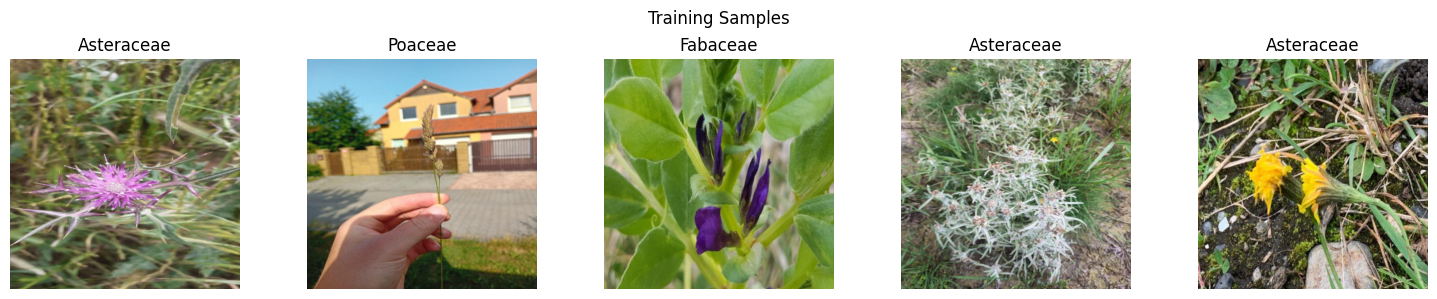

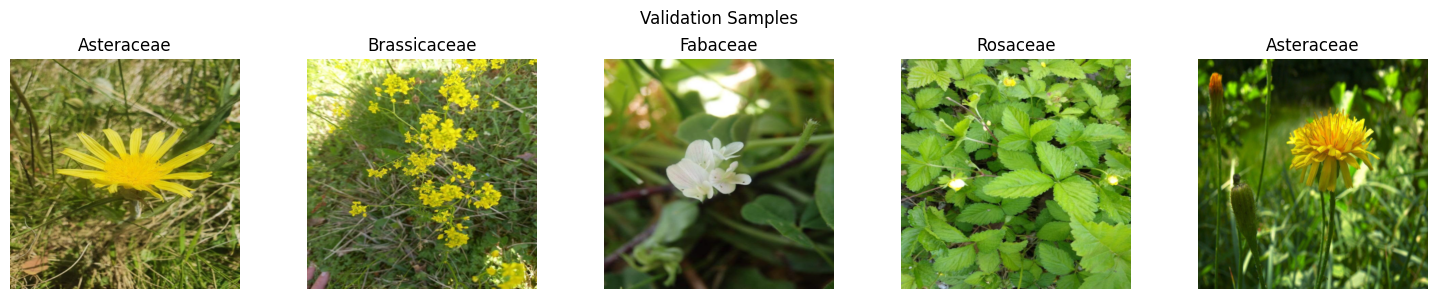

In [12]:
# Checks - check if Class work properly

plant_train = PlantClefDataset(train_df, transform=plant_transform)
plant_val  = PlantClefDataset(val_df, transform=plant_transform)

# Checks
print(f"Number of classes in Training: {plant_train.num_classes}")
print("Classes:", plant_train.label_to_idx)

print(f"Total samples after filtering: {len(plant_train.df)}")
print(f"Unique families: {plant_train.df['family'].unique()}")
print("Number of samples per family:")
print(plant_train.df['family'].value_counts())

print(f"Number of classesin Validation: {plant_val.num_classes}")
print("Classes:", plant_val.label_to_idx)

print(f"Total samples after filtering: {len(plant_val.df)}")
print(f"Unique families: {plant_val.df['family'].unique()}")
print("Number of samples per family:")
print(plant_val.df['family'].value_counts())


# check if image can be loaded
import matplotlib.pyplot as plt

# Visualize N images from dataset (no normalization involved)
def visualize_dataset(dataset, title='Sample Images', num_images=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        img_tensor, label_onehot = dataset[i]

        # Convert tensor to HWC format and scale to [0, 255]
        img = img_tensor.permute(1, 2, 0).numpy()
        img = (img * 255).astype('uint8')

        # Get label name from one-hot
        label_idx = label_onehot.argmax().item()
        label_name = dataset.idx_to_label[label_idx]

        # Plot the image
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(label_name)
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize training and validation datasets
visualize_dataset(plant_train, title="Training Samples")
visualize_dataset(plant_val, title="Validation Samples")


### **Preprocess Dataset - Prepare Quadrat Images for Training and Validation**

In [15]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import random
from torch.utils.data import DataLoader

class QuadratDataset(Dataset):
    def __init__(self, base_dataset, quad_size=4, transform=None):
        self.base = base_dataset
        self.quad_size = quad_size  # e.g. 4 for 2x2 grid
        self.transform = transform
        self.num_classes = self.base.num_classes

    def __len__(self):
        return len(self.base) // self.quad_size

    def __getitem__(self, idx):
        imgs, labels = [], []

        for _ in range(self.quad_size):
            # Randomly select a single-plant image and its one-hot label
            img, lbl = self.base[random.randint(0, len(self.base) - 1)]
            imgs.append(transforms.ToPILImage()(img))  # Convert back to PIL for stitching
            labels.append(lbl)

        # Assume all images same size, create blank 2x2 canvas
        w, h = imgs[0].size
        quad = Image.new('RGB', (w*2, h*2))

        coords = [(0, 0), (w, 0), (0, h), (w, h)]
        for img_patch, xy in zip(imgs, coords):
            quad.paste(img_patch, xy)

        if self.transform:
            quad = self.transform(quad)

        # Multi-label target (merge all 4 labels)
        ml_label = torch.zeros(self.num_classes)
        for lbl in labels:
            ml_label = torch.logical_or(ml_label, lbl.bool()).float()

        return quad, ml_label


quadrat_transform = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),  # Scales to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [16]:
# Create single-plant datasets
train_base = PlantClefDataset(train_df, transform=plant_transform)
val_base = PlantClefDataset(val_df, transform=plant_transform)

# Create quadrat datasets for training and validation
quadrat_train = QuadratDataset(train_base, quad_size=4, transform=quadrat_transform)
quadrat_val = QuadratDataset(val_base, quad_size=4, transform=quadrat_transform)

train_loader = DataLoader(quadrat_train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(quadrat_val, batch_size=batch_size, shuffle=False, num_workers=4)

In [17]:
# Checks
print(f"Total samples in quadrat_test: {len(quadrat_train)}")
print(f"Total samples in quadrat_test: {len(quadrat_val)}")

Total samples in quadrat_test: 2000
Total samples in quadrat_test: 500


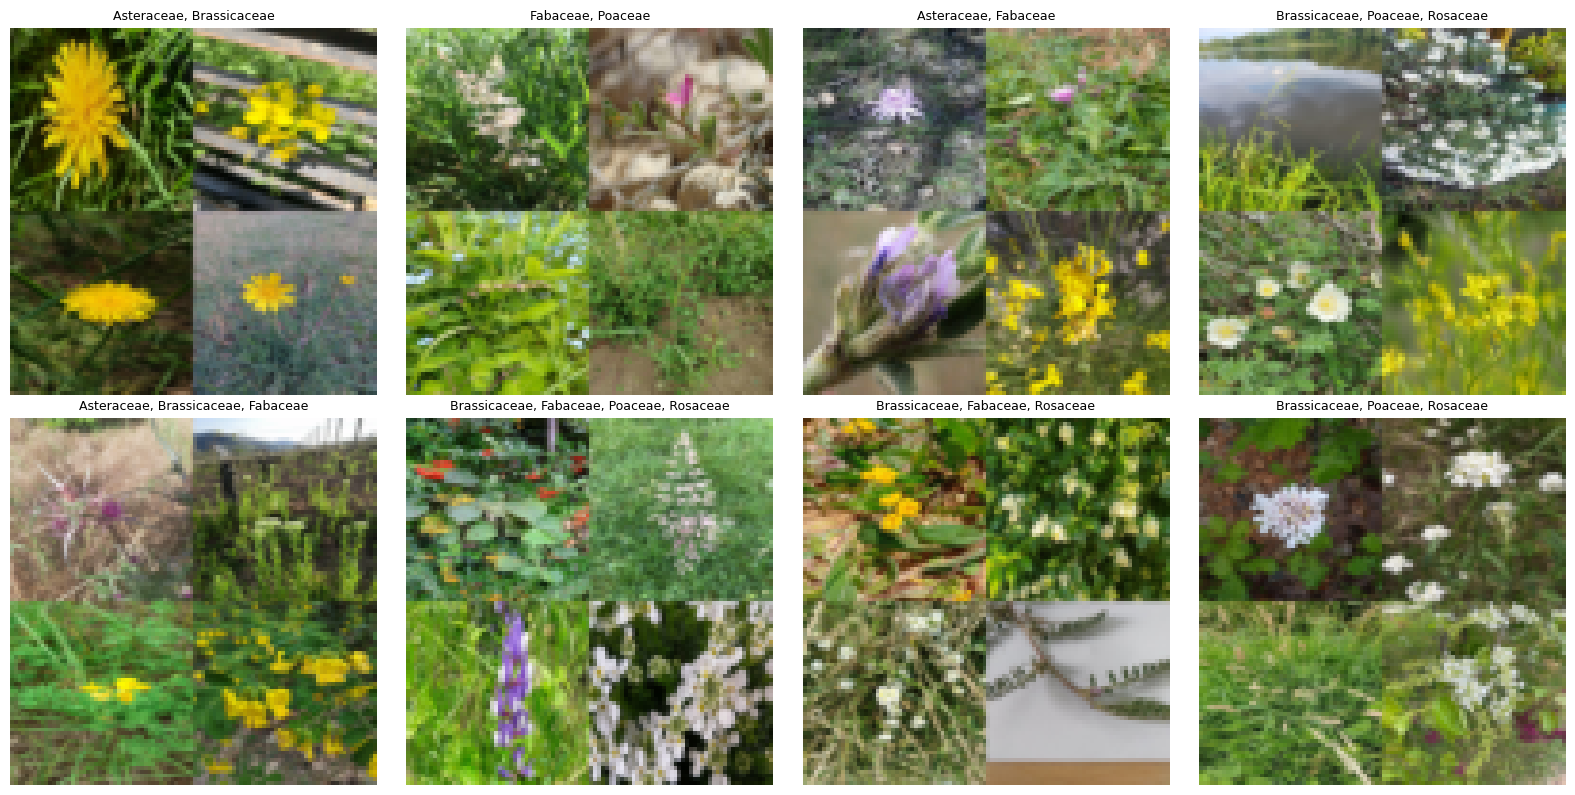

In [19]:
# Checks
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Get one batch from the training loader
images, labels = next(iter(train_loader))  # or val_loader

# De-normalize helper (reverse normalization)
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,1,3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1,1,3)
    return tensor * std + mean

# Plot the first few images with labels
plt.figure(figsize=(16, 8))
for i in range(8):  # Show 8 samples
    img = images[i].permute(1, 2, 0).detach().cpu()  # CHW -> HWC
    img = denormalize(img).numpy()
    img = np.clip(img, 0, 1)

    # Get label indices
    label_idxs = torch.nonzero(labels[i]).squeeze().tolist()
    if isinstance(label_idxs, int): label_idxs = [label_idxs]

    # Convert label indices to family names
    label_names = [train_loader.dataset.base.idx_to_label[idx] for idx in label_idxs]

    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(", ".join(label_names), fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


# **MODEL**

In [20]:
import torch, timm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import numpy as np

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = timm.create_model('efficientnet_lite0', pretrained=True, num_classes=quadrat_train.num_classes)
for p in model.parameters():
    p.requires_grad = False
for p in model.get_classifier().parameters():
    p.requires_grad = True

model = model.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


model.safetensors:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

In [22]:
# Checks

model

from torchinfo import summary
summary(model=model,
        input_size=(1, 3, 96, 96),  # match model expected input size
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                   [1, 3, 96, 96]       [1, 5]               --                   Partial
├─Conv2d (conv_stem)                          [1, 3, 96, 96]       [1, 32, 48, 48]      (864)                False
├─BatchNormAct2d (bn1)                        [1, 32, 48, 48]      [1, 32, 48, 48]      64                   False
│    └─Identity (drop)                        [1, 32, 48, 48]      [1, 32, 48, 48]      --                   --
│    └─ReLU6 (act)                            [1, 32, 48, 48]      [1, 32, 48, 48]      --                   --
├─Sequential (blocks)                         [1, 32, 48, 48]      [1, 320, 3, 3]       --                   False
│    └─Sequential (0)                         [1, 32, 48, 48]      [1, 16, 48, 48]      --                   False
│    │    └─DepthwiseSeparableConv (0)        [1, 32, 48, 48]      [1, 16, 48, 4

# **TRAINING**

In [23]:
import time 
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import copy

def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=10, save_path='best_model.pth'):
    train_losses = []
    val_losses = []
    best_f1 = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    start_time = time.time()  # ⏱️ Start tracking total time

    for epoch in range(epochs):
        epoch_start = time.time()  # ⏱️ Time per epoch start
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate
        val_loss, val_f1 = evaluate_model(model, val_loader, loss_fn, device)
        val_losses.append(val_loss)

        epoch_time = time.time() - epoch_start  # ⏱️ Time per epoch
        print(f"Epoch {epoch+1}/{epochs} | Time: {epoch_time:.2f}s | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

        # Save best model with epoch-based filename
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())

            # Save only model weights (optional)
            best_model_filename = f"best_model_epoch_{epoch+1}.pth"
            torch.save(best_model_wts, best_model_filename)

            # Save full checkpoint (model + optimizer + epoch)
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': best_model_wts,
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_f1': val_f1,
            }, f"checkpoint_epoch_{epoch+1}.pth")

            print(f"✅ Best model saved as '{best_model_filename}'")

    # Save final checkpoint (last state)
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, 'final_checkpoint.pth')

    print("✅ Final model checkpoint saved as 'final_checkpoint.pth'")

    total_time = time.time() - start_time  # ⏱️ Total time
    print(f"⏱️ Total training time: {total_time / 60:.2f} minutes")

    # Plot loss history
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Load best model weights into model for further use
    model.load_state_dict(best_model_wts)



def evaluate_model(model, val_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_preds, all_trues = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)  # Already one-hot from dataset

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            all_preds.append(preds)
            all_trues.append(labels.cpu().numpy())

    y_pred = np.vstack(all_preds)
    y_true = np.vstack(all_trues)
    f1 = f1_score(y_true, y_pred, average='samples')  # multi-label F1
    return total_loss / len(val_loader), f1



Epoch 1/5 | Time: 72.76s | Train Loss: 1.6177 | Val Loss: 1.8418 | Val F1: 0.5251
✅ Best model saved as 'best_model_epoch_1.pth'
Epoch 2/5 | Time: 72.43s | Train Loss: 1.6452 | Val Loss: 1.7294 | Val F1: 0.5173
Epoch 3/5 | Time: 72.38s | Train Loss: 1.5792 | Val Loss: 1.7595 | Val F1: 0.5547
✅ Best model saved as 'best_model_epoch_3.pth'
Epoch 4/5 | Time: 72.81s | Train Loss: 1.5572 | Val Loss: 1.7007 | Val F1: 0.5564
✅ Best model saved as 'best_model_epoch_4.pth'
Epoch 5/5 | Time: 72.15s | Train Loss: 1.5704 | Val Loss: 1.8604 | Val F1: 0.5596
✅ Best model saved as 'best_model_epoch_5.pth'
✅ Final model checkpoint saved as 'final_checkpoint.pth'
⏱️ Total training time: 6.05 minutes


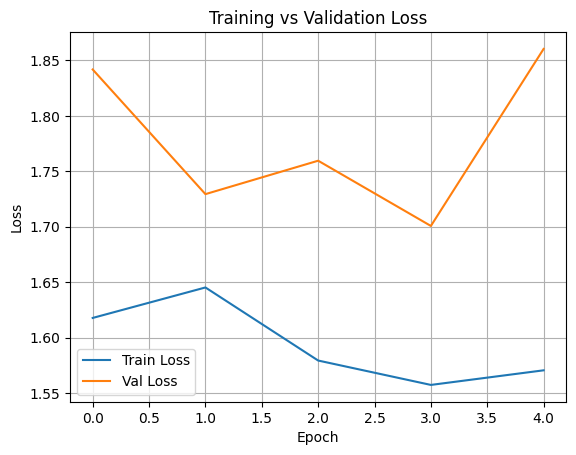

In [24]:
train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=5)

In [25]:
torch.save(model.state_dict(), 'final_model.pth')
print("💾 Final model saved as 'final_model.pth'.")

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 10,
    # add any other training info here
}, 'final_checkpoint.pth')


💾 Final model saved as 'final_model.pth'.


# **EVALUATION**

In [35]:
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import torch

def evaluate_quadrats(model, quad_loader, idx_to_label, threshold=0.5, device='cuda'):
    model.eval()
    pred_bin_all = []
    true_bin_all = []
    pred_class_names_all = []
    true_class_names_all = []

    with torch.no_grad():
        for images, labels in quad_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds_bin = (probs > threshold).astype(int)

            pred_bin_all.extend(preds_bin)
            true_bin_all.extend(labels.cpu().numpy())

            # Convert predictions to class names
            for pred_vec in preds_bin:
                pred_classes = [idx_to_label[i] for i in range(len(pred_vec)) if pred_vec[i] == 1]
                pred_class_names_all.append(pred_classes)

            # Convert true labels to class names
            for true_vec in labels.cpu().numpy():
                true_classes = [idx_to_label[i] for i in range(len(true_vec)) if true_vec[i] == 1]
                true_class_names_all.append(true_classes)

    # Metrics
    y_pred = np.vstack(pred_bin_all)
    y_true = np.vstack(true_bin_all)

    f1 = f1_score(y_true, y_pred, average='samples', zero_division=0)
    precision = precision_score(y_true, y_pred, average='samples', zero_division=0)
    recall = recall_score(y_true, y_pred, average='samples', zero_division=0)

    print(f"\n📊 Evaluation Metrics:")
    print(f"✅ F1 Score   : {f1:.4f}")
    print(f"✅ Precision  : {precision:.4f}")
    print(f"✅ Recall     : {recall:.4f}\n")

    return pred_class_names_all, y_pred, y_true, true_class_names_all


In [36]:
pred_class_names, pred_bin, true_bin, true_class_names = evaluate_quadrats(model, val_loader, plant_val.idx_to_label, threshold=0.5, device=device)


📊 Evaluation Metrics:
✅ F1 Score   : 0.5635
✅ Precision  : 0.5958
✅ Recall     : 0.5847



In [37]:
# Show first N results (e.g., N=5)
N = 5
for i in range(min(N, len(pred_class_names))):
    print(f"🟩 Sample {i+1}")
    print("✅ Predicted :", pred_class_names[i])
    print("🎯 Ground Truth:", true_class_names[i])
    print("-" * 50)


🟩 Sample 1
✅ Predicted : ['Asteraceae', 'Brassicaceae', 'Fabaceae', 'Rosaceae']
🎯 Ground Truth: ['Asteraceae', 'Fabaceae', 'Poaceae']
--------------------------------------------------
🟩 Sample 2
✅ Predicted : ['Asteraceae', 'Poaceae', 'Rosaceae']
🎯 Ground Truth: ['Brassicaceae', 'Poaceae']
--------------------------------------------------
🟩 Sample 3
✅ Predicted : ['Brassicaceae']
🎯 Ground Truth: ['Fabaceae', 'Poaceae', 'Rosaceae']
--------------------------------------------------
🟩 Sample 4
✅ Predicted : ['Brassicaceae', 'Fabaceae', 'Rosaceae']
🎯 Ground Truth: ['Brassicaceae', 'Fabaceae', 'Poaceae', 'Rosaceae']
--------------------------------------------------
🟩 Sample 5
✅ Predicted : ['Asteraceae', 'Fabaceae', 'Poaceae', 'Rosaceae']
🎯 Ground Truth: ['Asteraceae', 'Fabaceae', 'Poaceae', 'Rosaceae']
--------------------------------------------------
